<a href="https://colab.research.google.com/github/annykay/NoiseInDataImpact/blob/main/FlippingNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flipping Noise

In [1]:
# Imports 

import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Noise intoduction and processing functions

def flipping(k, features_list, df_features):
  df_corrupted = copy.copy(df_features)
  df_size = len(df_corrupted)
  for i in tqdm(range(round(k*df_size))):
    for feature_index in features_list:
      sample_1 = random.randint(0, df_size-1)
      sample_2 = random.randint(0, df_size-1)
      df_corrupted.iloc[sample_1, feature_index], df_corrupted.iloc[sample_2, feature_index] = df_corrupted.iloc[sample_2, feature_index], df_corrupted.iloc[sample_1, feature_index]
  return df_corrupted

def noise_analysis(noise_levels, features_list, df_features, df_labels, models):
  result_scores_test = []
  result_scores_train = []
  for i, levels in enumerate(noise_levels):
    print('Working on noise level', levels)
    df_corrupted = flipping(levels, features_list, df_features)
    x = df_corrupted
    y = df_labels
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 123)
    noise_scores_test = []
    noise_scores_train = []
    for model in models:
      model.fit(X_train, y_train)
      noise_scores_test.append(f1_score(y_test, model.predict(X_test), average='micro'))
      noise_scores_train.append(f1_score(y_train, model.predict(X_train), average='micro'))
    result_scores_test.append(noise_scores_test)
    result_scores_train.append(noise_scores_train)
  return np.array(result_scores_test).T, np.array(result_scores_train).T

In [3]:
# Loading sample dataset

stellar_features = pd.read_csv('stellar_features.csv')
stellar_labels = pd.read_csv('stellar_labels.csv')
stellar_labels = stellar_labels.drop('Unnamed: 0', axis=1)
stellar_features = stellar_features.drop('Unnamed: 0', axis=1)

In [4]:
# Training models on noisy data

features_list = np.arange(9)

noise_levels = [0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8]

models = [DecisionTreeClassifier(random_state=0, max_depth=9),
          RandomForestClassifier(max_depth=14, n_estimators=90, n_jobs=-1),
          KNeighborsClassifier(n_neighbors=3),
          XGBClassifier(random_state=0, learning_rate = 0.1, n_estimators=100, max_depth=12),
          LogisticRegression(random_state=0, n_jobs=-1, C=2010)
          ]
model_names = ['DTC', 'RFC', 'KNN', 'XGB', 'LRC']
model_dict_all_test = {}
model_dict_all_train = {}
results_scores_test, results_scores_train = noise_analysis(noise_levels, features_list, stellar_features, stellar_labels, models)
for i, name in enumerate(model_names):
  model_dict_all_test[name] = results_scores_test[i]
  model_dict_all_train[name] = results_scores_train[i]

Working on noise level 0


0it [00:00, ?it/s]


Working on noise level 0.05


100%|██████████| 2552/2552 [00:06<00:00, 397.65it/s]


Working on noise level 0.1


100%|██████████| 5105/5105 [00:12<00:00, 408.28it/s]


Working on noise level 0.2


100%|██████████| 10210/10210 [00:25<00:00, 404.17it/s]


Working on noise level 0.4


100%|██████████| 20419/20419 [00:52<00:00, 386.94it/s]


Working on noise level 0.6


100%|██████████| 30629/30629 [01:16<00:00, 401.24it/s]


Working on noise level 0.8


100%|██████████| 40838/40838 [01:41<00:00, 400.40it/s]


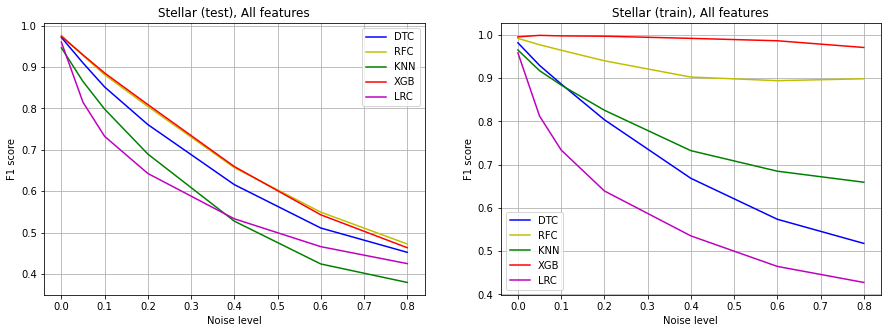

In [5]:
# Plotting results

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

colors = ['b', 'y', 'g', 'r', 'm']

for keys, color in zip(model_dict_all_test, colors):
  axes[0].plot(noise_levels, model_dict_all_test[keys], color=color, label=keys)
axes[0].legend()
axes[0].set_xlabel('Noise level')
axes[0].set_ylabel('F1 score')
#plt.ylim(0.91, .99)
axes[0].grid()
axes[0].set_title('Stellar (test), All features')

for keys, color in zip(model_dict_all_train, colors):
  axes[1].plot(noise_levels, model_dict_all_train[keys], color=color, label=keys)
axes[1].legend()
axes[1].set_xlabel('Noise level')
axes[1].set_ylabel('F1 score')
#plt.ylim(0.91, .99)
axes[1].grid()
axes[1].set_title('Stellar (train), All features')

plt.show()